In [76]:
import pandas as pd
import numpy as np
import datetime as dt
from pathlib import Path
from datetime import datetime, timedelta
from dotenv import load_dotenv
import os
import requests
import alpaca_trade_api as tradeapi
import matplotlib.pyplot as plt
import hvplot.pandas
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#Import SKLearn Library and Classes
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [141]:
#set path to Features CSV and read in CSV
amd_df = pd.read_pickle('Resources/amd_features_df.pickle')
amd_df.head()

,AMD Close,AMD Volume,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,rvol,rvol SD,rvol signal,daily returns
2019-07-26,34.01,40369473,32.8090,1.163419,33.972419,31.645581,0.0,-1.0,-1.0,0.912169,0.913205,0.0,0.010398
2019-07-29,33.48,42767769,32.9640,1.020501,33.984501,31.943499,0.0,0.0,0.0,0.962055,0.931985,1.0,-0.015584
2019-07-30,33.87,54286925,33.0975,0.949785,34.047285,32.147715,0.0,0.0,0.0,1.222984,0.963948,1.0,0.011649
2019-07-31,30.43,110558754,33.0560,1.047414,34.103414,32.008586,1.0,0.0,1.0,2.296310,1.130589,1.0,-0.101565
2019-08-01,29.86,76711829,32.9900,1.202024,34.192024,31.787976,1.0,0.0,1.0,1.506163,1.185642,1.0,-0.018732


In [178]:
#Create new trading signals Df, Set index as datetime object and drop extraneous columns
trading_signals_df = pd.DataFrame()

In [179]:
#create features only dataframe by shifting feature signal by user defined target
threshold = .01
shift = 1
x_var_list = ['bollinger_signal', 'rvol signal']

trading_signals_df[x_var_list] = amd_df[x_var_list].shift(1)

trading_signals_df = trading_signals_df.set_index(pd.to_datetime(amd_df.index, infer_datetime_format=True))
trading_signals_df.head()

,bollinger_signal,rvol signal
2019-07-26,NaN,NaN
2019-07-29,-1.0,0.0
2019-07-30,0.0,1.0
2019-07-31,0.0,1.0
2019-08-01,1.0,1.0


In [180]:
#add dependent variable for targeting at least 1% positive return
trading_signals_df['Positive Return'] = np.where(amd_df['daily returns'].shift(shift) >= threshold, 1, 0)

In [181]:
#drop Na
trading_signals_df = trading_signals_df.dropna()
trading_signals_df

,bollinger_signal,rvol signal,Positive Return
2019-07-29,-1.0,0.0,1
2019-07-30,0.0,1.0,0
2019-07-31,0.0,1.0,1
2019-08-01,1.0,1.0,0
2019-08-02,1.0,1.0,0
...,...,...,...
2019-12-23,-1.0,1.0,1
2019-12-24,-1.0,1.0,1
2019-12-26,-1.0,0.0,1
2019-12-27,-1.0,1.0,0


In [182]:
#Assign Training and testing windows

training_start = trading_signals_df.index.min()
training_end = '2019-07-30'

# Construct testing start and end dates
testing_start =  '2019-08-01'
testing_end = trading_signals_df.index.max()

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2019-07-29 00:00:00
Training End: 2019-07-30
Testing Start: 2019-08-01
Testing End: 2019-12-30 00:00:00


In [183]:
# Construct the X_train and y_train datasets
X_train = trading_signals_df[x_var_list][training_start:training_end]
y_train = trading_signals_df['Positive Return'][training_start:training_end]

In [184]:
# Construct the X_test and y_test datasets
X_test = trading_signals_df[x_var_list][testing_start:testing_end]
y_test = trading_signals_df['Positive Return'][testing_start:testing_end]

In [185]:
#Train Random Forest Model
# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(X_test)

In [186]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Value"] = predictions
Results['Daily Returns'] = amd_df['daily returns']
Results

,Positive Return,Predicted Value,Daily Returns
2019-08-01,0,0,-0.018732
2019-08-02,0,0,-0.013396
2019-08-05,0,0,-0.050238
2019-08-06,0,0,0.031094
2019-08-07,1,0,0.011785
...,...,...,...
2019-12-23,1,0,0.029665
2019-12-24,1,0,0.023312
2019-12-26,1,1,0.002364
2019-12-27,0,0,-0.009863


In [187]:
Results['Predicted Value'].sum()

28

In [190]:
Results['Positive Return'].sum()

40

<AxesSubplot:>

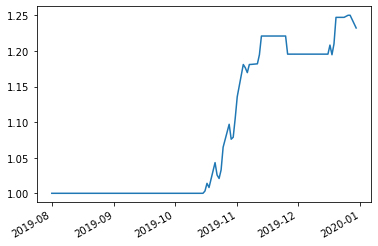

In [188]:
# Calculate cumulative return of model and plot the result
(1 + (Results['Daily Returns'] * Results['Predicted Value'])).cumprod().plot()

<AxesSubplot:>

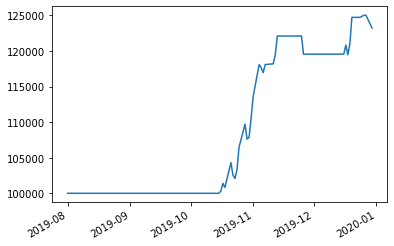

In [189]:
# Set initial capital allocation
initial_capital = 100000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * (1 + (Results['Daily Returns'] * Results['Predicted Value'])).cumprod()
cumulative_return_capital.plot()